# Final Figures

This notebook includes the code to render the final figures for the paper submission. Plotting figures can be rather particular with a lot of parameter experimentation, so we broke it into a separate notebook from the more exploratory analysis. Those earlier notebook helped us think, this one is aiming to communicate with others.

In [1]:
import os
import json
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 0. Load Data

In [3]:
# load data from our csv files
df_nb = pd.read_csv('../data/csv/nb_metadata.csv')
df_cell = pd.read_csv('../data/csv/cell_metadata.csv')
df_repo = pd.read_csv('../data/csv/repo_metadata.csv')
df_readme = pd.read_csv('../data/csv/repo_readme.csv')

In [4]:
# filter out forked repos
df_nb = df_nb[df_nb.repo_fork == False] 

# remove unwanted columns
del df_nb['Unnamed: 0']
del df_nb['max_filesize']
del df_nb['min_filesize']
del df_nb['owner_html_url']
del df_nb['query_page']
del df_nb['repo_private']
del df_nb['repo_fork']
del df_nb['repo_html_url']
del df_nb['kernel_lang']
del df_nb['kernel_name']
del df_nb['num_cells']

In [5]:
# clean cell data
del df_cell['Unnamed: 0']
del df_cell['Unnamed: 0.1']

df_cell['workbook_index'].fillna(0, inplace = True)
df_cell['workbook_index'] = df_cell['workbook_index'].astype(int)

df_cell['num_words'].fillna(0, inplace = True)
df_cell['num_words'] = df_cell['num_words'].astype(int)

df_cell['lines_of_code'].fillna(0, inplace = True)
df_cell['lines_of_code'] = df_cell['lines_of_code'].astype(int)

In [6]:
# filter out forked repos
df_repo = df_repo[df_repo.fork == False] 

# deleted unnecessary columns
del df_repo['stargazers_count']
del df_repo['Unnamed: 0']
del df_repo['fork']
del df_repo['private']

In [7]:
# delete unnecesary columns in readme data
del df_readme['Unnamed: 0']
del df_readme['type']

## 1. Restrict to only notebooks we have complete data for and do additional cleaning

In [8]:
# 1. num nbs that did not download 
num_nbs_not_queried = 0
missed_ranges = []

num_nbs_bad_result = 0
ranges_w_bad_result = []

# find notebooks not downloaded due to more than 1000 notebooks having same filesize
with open ('../logs/nb_metadata_query_log.txt', 'r') as log:
    for l in log:
        if l.startswith('TOO MANY RESULTS'):
            num_nbs_not_queried += int(l.split()[-2])
            missed_ranges.append(l.split()[-4])

# find notebooks not downloaded due to incomplete response from github
with open('../logs/nb_metadata_cleaning_log.txt', 'r') as log:
    for l in log:
        parts = l.split()        
        if parts[2] == 'incomplete':
            with open('../data/api_results/nb_metadata/' + parts[0], 'r') as json_file:                            
                file_dict = json.load(json_file)
                total_expected = file_dict['total_count']
                expected_pages = math.ceil(total_expected / 100.0)
                current_page = int(parts[0].split('_')[-1].split('.')[0][1:])
                current_items = len(file_dict['items'])
                
                if current_page < expected_pages and current_items < 100:
                    num_nbs_bad_result += (100 - current_items)
                    ranges_w_bad_result.append(l.split('_')[2:4])
                elif total_expected % 100 > current_items:
                    num_nbs_bad_result += (total_expected % 100 - current_items)
                    ranges_w_bad_result.append(l.split('_')[2:4])

num_nbs_did_not_download = num_nbs_not_queried + num_nbs_bad_result

# 2. nbs with metadata
nbs_w_file = df_nb.nb_id.unique()

# 3. nbs with cell data
df_nb_content_count = ( df_cell[[
                            'nb_id', 
                            'lines_of_code', 
                            'num_words']]
                                .groupby('nb_id')
                                .sum() )

nbs_wo_content = list( df_nb_content_count[
    df_nb_content_count.lines_of_code == 0][
    df_nb_content_count.num_words == 0].index )

nbs_w_cells = df_cell[~df_cell.nb_id.isin(nbs_wo_content)].nb_id.unique()

# 4. nbs with repo metadata
repos_w_metadata = df_repo.id.unique()
nbs_w_repo_data = df_nb[df_nb.repo_id.isin(repos_w_metadata)]['nb_id']

# 5. nbs with all data
nb_repo_cell_ids = np.intersect1d(np.intersect1d(nbs_w_file, nbs_w_repo_data), nbs_w_cells)
nb_repo_ids = df_nb[df_nb.nb_id.isin(nb_repo_cell_ids)]['repo_id'].unique()

# 6. repos with all data

print('Of the %s notebooks available on Github'% (df_nb.shape[0] + num_nbs_did_not_download))
print('%s were returned by our search query' % df_nb.shape[0])
print('%s notebooks not returned by our search' % num_nbs_did_not_download)
print('')
print('%s had repo data we could scrape' % nbs_w_repo_data.shape[0])
print('%s had cell data we could extract' % nbs_w_cells.shape[0])
print('Leaving %s that we can analyze fully' % nb_repo_cell_ids.shape[0])
print('')
print('Meaning we have dropped %s nbs in total from the analysis'% (df_nb.shape[0] 
                                                                    + num_nbs_did_not_download 
                                                                    - nb_repo_cell_ids.shape[0]))
print('or %s percent of the dataset' % str((df_nb.shape[0] 
                                         + num_nbs_did_not_download 
                                         - nb_repo_cell_ids.shape[0])
                                         /(df_nb.shape[0] 
                                         + num_nbs_did_not_download)*100)[0:5])

/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Of the 1294163 notebooks available on Github
1250857 were returned by our search query
43306 notebooks not returned by our search

1246469 had repo data we could scrape
1233055 had cell data we could extract
Leaving 1227573 that we can analyze fully

Meaning we have dropped 66590 nbs in total from the analysis
or 5.145 percent of the dataset


In [9]:
df_nb_complete = df_nb[df_nb.nb_id.isin(nb_repo_cell_ids)]
df_repo_complete = df_repo[df_repo.id.isin(nb_repo_ids)]
df_cell_complete = df_cell[df_cell.nb_id.isin(nb_repo_cell_ids)]
df_readme_complete = df_readme[df_readme.repo_id.isin(nb_repo_ids)]

print('Our cleaned data consists of:')
print('%s notebooks' % df_nb_complete.shape[0])
print('%s repos' % df_repo_complete.shape[0])
print('%s readmes' % df_readme_complete.shape[0])
print('%s cells' % df_cell_complete.shape[0])
print('%s users' % df_nb_complete.owner_login.unique().shape[0])

Our cleaned data consists of:
1227573 notebooks
191402 repos
141159 readmes
34486368 cells
100503 users


In [10]:
# get size of each nb file
nb_files = [x for x in os.listdir('../data/notebooks') if x.endswith('.ipynb')]
sizes = [[n.split('_')[1].split('.')[0], os.path.getsize('../data/notebooks/' + n)] for n in nb_files]

# merge size data back into main table
df_nb_sizes = pd.DataFrame(sizes)
df_nb_sizes.columns = ['nb_id', 'size']
df_nb_complete = df_nb_complete.merge(df_nb_sizes, 
                      on = 'nb_id',
                      how = 'left')

In [11]:
# calculate sum of cell counts for each nb
df_nb_cell_counts = (df_cell[['nb_id',
                             'lines_of_code',
                             'num_display_data', 
                             'num_error', 
                             'num_execute_result', 
                             'num_stream',
                             'num_words', 
                             'num_imports',  
                             'num_headers',
                             'num_links', 
                             'num_functions',
                             'num_classes', 
                             'num_comment_lines', 
                             'num_comment_words']]
                            .groupby('nb_id')
                            .agg('sum'))

df_nb_cell_types = (df_cell[['nb_id', 
                            'cell_type']]
                            .groupby('nb_id')['cell_type']
                            .value_counts()
                            .unstack(fill_value=0))

df_nb_cell_types['nb_id'] = df_nb_cell_types.index
df_nb_cell_counts['nb_id'] = df_nb_cell_counts.index

In [12]:
# get max cell content per nb for calculation of how well markdown, comments, etc are distributed
df_nb_cell_max = (df_cell[['nb_id',
                             'lines_of_code',
                             'num_display_data', 
                             'num_error', 
                             'num_execute_result', 
                             'num_stream',
                             'num_words', 
                             'num_imports',  
                             'num_headers',
                             'num_links', 
                             'num_functions',
                             'num_classes', 
                             'num_comment_lines', 
                             'num_comment_words']]
                            .groupby('nb_id')
                            .agg('max'))

print(df_nb_cell_counts.shape[0])
print(df_nb_cell_max.shape[0])

1239355
1239355


In [13]:
df_nb_cell_types['markdown'] = df_nb_cell_types['markdown'] + df_nb_cell_types['heading']
df_nb_cell_types['other'] = ( df_nb_cell_types['altset']
                             + df_nb_cell_types['future cell']
                             + df_nb_cell_types['interactivecode']
                             + df_nb_cell_types['markdownn']
                             + df_nb_cell_types['moarkdown']
                             + df_nb_cell_types['mycode']
                             + df_nb_cell_types['plaintext']
                             + df_nb_cell_types['strategy']
                             + df_nb_cell_types['task']
                             + df_nb_cell_types['text']
                            )

del df_nb_cell_types['altset']
del df_nb_cell_types['heading']
del df_nb_cell_types['future cell']
del df_nb_cell_types['interactivecode']
del df_nb_cell_types['markdownn']
del df_nb_cell_types['moarkdown']
del df_nb_cell_types['mycode']
del df_nb_cell_types['plaintext']
del df_nb_cell_types['strategy']
del df_nb_cell_types['task']
del df_nb_cell_types['text']

In [14]:
df_nb_complete = df_nb_complete.merge(df_nb_cell_counts,
                                     how = 'left',
                                     on = 'nb_id')


df_nb_complete = df_nb_complete.merge(df_nb_cell_types,
                                     how = 'left',
                                     on = 'nb_id')

## 2. Plot figure regarding notebook length in various content measures

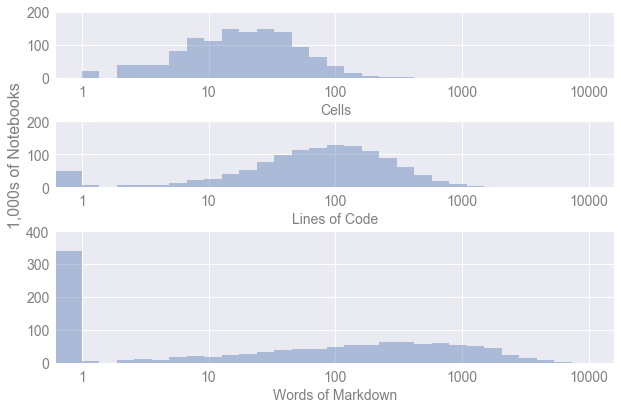

In [131]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, gridspec_kw = {'height_ratios':[1, 1, 2]})
f.set_size_inches(10, 3)
plt.subplots_adjust(top=1.75)
f.subplots_adjust(hspace=.5)

df_nb_complete.num_cells = df_nb_complete.code + df_nb_complete.markdown + df_nb_complete.raw + df_nb_complete.other
sns.distplot(df_nb_complete.num_cells, kde=False, ax = ax1, bins = np.append(0, np.logspace(0,4,30)))
ax1.set_xscale('log')
# ax1.set_title('Cells', fontsize = 16, position = [0.09, 0.66], color='#666666')
ax1.set_xlabel('Cells')
ax1.set_ylim([0,200000])
#ax1.set_xlim([-1,10000])
ax1.set(xticklabels=[])
# ax1.title.set_position()
# ax1.title.set_fontsize(18)

sns.distplot(df_nb_complete.lines_of_code, kde=False, ax = ax2, bins = np.append(0, np.logspace(0,4,30)))
ax2.set_xscale('log')
# ax2.set_title('Lines of Code', fontsize = 16, position = [0.15, 0.66], color='#666666')
ax2.set_ylabel('1,000s of Notebooks', color='grey')
ax2.set_xlabel('Lines of Code', color='grey')
# ax2.set_xlabel('')
ax2.set_ylim([0,200000])
# ax2.set_xlim([0,10000])
ax2.yaxis.label.set_fontsize(16)

sns.distplot(df_nb_complete.num_words, kde=False, ax = ax3, bins = np.append(0, np.logspace(0,4,30)))
ax3.set_xscale('log')
# ax3.set_title('Words of Markdown', fontsize = 16, position = [0.19, 0.81], color='#666666')
ax3.set_xlabel('Words of Markdown')
#ax3.set_xlim([0,10000])
ax3.set_ylim([-1,400000])

from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1000))
for axis in [ax1, ax2, ax3]:
    axis.xaxis.set_major_formatter(ScalarFormatter())
    axis.yaxis.set_major_formatter(ticks)

    
for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
    item.set_color('grey')
    
for item in ([ax2.xaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(14)
    item.set_color('grey')
    
for item in ([ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(14)
    item.set_color('grey')

## 3. Plot notebook content distribution
Note that [another notebook](8_markdown_distribution.ipynb) was used to generate these numbers which are essentially the number of cells at each percentange of the notebook's length (1%, 2%, 3%, ...) that were markdown, code, or other. 

In [21]:
mc = np.array([ 681656.,  681448.,  654927.,  617157.,  568850.,  527187.,
        505607.,  487427.,  473321.,  461993.,  443669.,  439591.,
        413673.,  408015.,  406886.,  397629.,  395129.,  384040.,
        383035.,  379163.,  376154.,  372965.,  374807.,  369496.,
        372040.,  365137.,  360575.,  357654.,  359874.,  362077.,
        357040.,  357851.,  356846.,  356890.,  354121.,  352277.,
        348171.,  345510.,  345743.,  350173.,  354475.,  352324.,
        352162.,  349882.,  349489.,  349945.,  348235.,  351741.,
        347730.,  347244.,  343713.,  342874.,  342404.,  338813.,
        341306.,  336659.,  337670.,  333627.,  327644.,  329946.,
        335442.,  335609.,  329883.,  329418.,  330650.,  327157.,
        328648.,  326520.,  329482.,  328495.,  327951.,  317874.,
        317334.,  310725.,  310494.,  311195.,  309976.,  312215.,
        313761.,  312618.,  313100.,  306846.,  304685.,  306701.,
        302247.,  300559.,  295462.,  291385.,  285329.,  281401.,
        278984.,  273352.,  271719.,  265017.,  263226.,  251645.,
        239295.,  234972.,  223165.,  208233.])

cc = np.array([ 514994.,  515200.,  541735.,  579666.,  628083.,  669691.,
        691308.,  709530.,  723691.,  735056.,  753474.,  757596.,
        783589.,  789194.,  790477.,  799787.,  802285.,  813441.,
        814294.,  818300.,  821325.,  824478.,  822649.,  828030.,
        825632.,  832488.,  837053.,  839998.,  837752.,  835481.,
        840534.,  839665.,  840655.,  840677.,  843495.,  845396.,
        849503.,  852141.,  851914.,  847449.,  843182.,  845286.,
        845275.,  847589.,  848000.,  847586.,  849255.,  845752.,
        849898.,  850378.,  853871.,  854733.,  855173.,  858797.,
        856230.,  860940.,  859885.,  863936.,  869819.,  867485.,
        862096.,  861969.,  867676.,  868129.,  866899.,  870316.,
        868856.,  871076.,  868137.,  868989.,  869457.,  879736.,
        880315.,  886935.,  887236.,  886444.,  887696.,  885323.,
        883786.,  884833.,  884267.,  890520.,  892417.,  890549.,
        895038.,  896762.,  901804.,  905843.,  911923.,  915912.,
        918375.,  924275.,  925937.,  932627.,  934357.,  945898.,
        958266.,  962513.,  974357.,  989261.])

oc = np.array([ 3681.,  3683.,  3669.,  3508.,  3398.,  3453.,  3416.,  3374.,
        3318.,  3281.,  3187.,  3143.,  3062.,  3115.,  2961.,  2908.,
        2910.,  2843.,  2995.,  2861.,  2845.,  2881.,  2868.,  2796.,
        2650.,  2697.,  2694.,  2670.,  2696.,  2764.,  2748.,  2806.,
        2821.,  2755.,  2706.,  2649.,  2648.,  2671.,  2665.,  2700.,
        2665.,  2712.,  2885.,  2851.,  2833.,  2791.,  2832.,  2829.,
        2694.,  2700.,  2738.,  2715.,  2745.,  2712.,  2786.,  2723.,
        2765.,  2757.,  2857.,  2889.,  2782.,  2742.,  2761.,  2773.,
        2771.,  2847.,  2816.,  2724.,  2701.,  2836.,  2912.,  2710.,
        2671.,  2660.,  2590.,  2681.,  2648.,  2782.,  2773.,  2869.,
        2953.,  2954.,  3218.,  3070.,  3035.,  2999.,  3054.,  3092.,
        3068.,  3005.,  2959.,  2691.,  2662.,  2673.,  2734.,  2774.,
        2756.,  2832.,  2795.,  2823.])

tt = mc + cc + oc

([<matplotlib.axis.YTick at 0x13ada9400>,
 <a list of 6 Text yticklabel objects>)

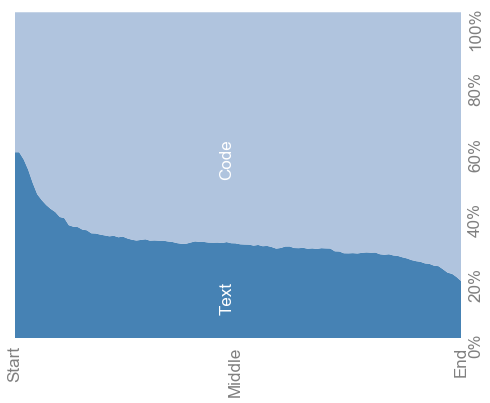

In [126]:
f, ax = plt.subplots(figsize=(8, 6))

x = np.arange(100)
y1 = cc / tt[0]

ax.fill_between(x, 0, 1-y1, facecolor='steelblue')
ax.fill_between(x, 1, 1-y1, facecolor='lightsteelblue')
ax.yaxis.tick_right()

f.text(0.48, 0.23,'Text', fontsize=17, rotation=90, color = 'white', fontweight=500)
f.text(0.48, 0.56,'Code', fontsize=17, rotation=90, color="white", fontweight=500)

# ax.set_title("Distribution of Content Across All Notebooks", fontsize = 16, color = 'grey', fontweight=600)
# ax.set_xlabel('Section of Notebook', fontsize = 14, color = 'grey', fontweight=600)
# ax.set_ylabel('Percent of Content Across All Notebooks', fontsize = 16, color = 'grey', fontweight=600)
ax.set_ylim(0,1)
ax.set_xlim(0,99)
plt.xticks([0,49,99], ['Start','Middle', 'End'], rotation=90, color='grey', fontsize = 17)
plt.yticks([0,0.2,0.4,0.6,0.8, 1], ['0%','20%','40%','60%','80%','100%'], rotation=90, color='grey', fontsize = 17)